In [4]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from public_tests import *
%matplotlib inline

In [5]:
# Set random seed for reproducibility
tf.random.set_seed(272)

# Define model size and load VGG19 with pre-trained ImageNet weights
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')
vgg.trainable = False

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


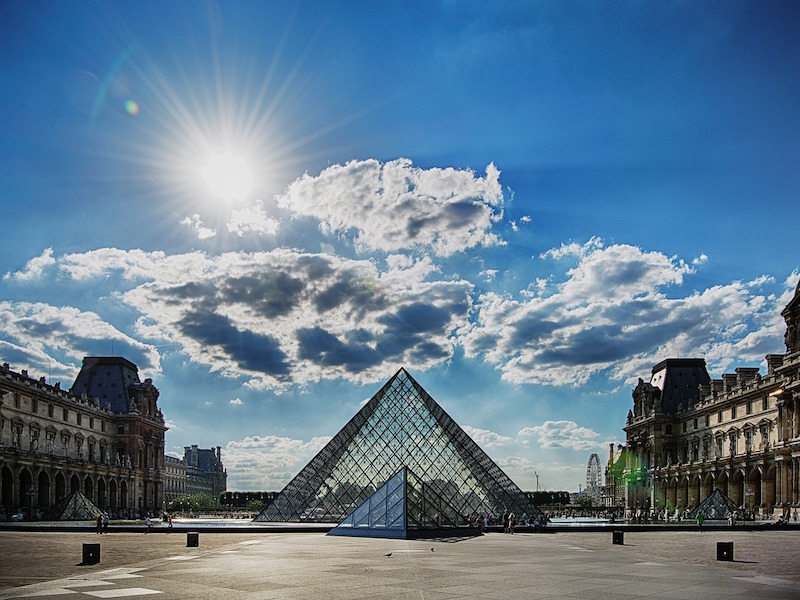

In [6]:
# Load and preprocess images
def load_and_process_img(path_to_img):
    img = Image.open(path_to_img)
    img = img.resize((img_size, img_size))
    img = np.array(img, dtype=np.float32)
    img = np.expand_dims(img, axis=0)
    return tf.keras.applications.vgg19.preprocess_input(img)

# Load images
content_image = load_and_process_img("images/louvre.jpg")
style_image = load_and_process_img("images/monet.jpg")

print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

In [7]:
# Function to compute content cost
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.reshape(a_C, shape=[1, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[1, -1, n_C])
    return tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4 * n_H * n_W * n_C)

In [8]:

compute_content_cost_test(compute_content_cost)

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)
All tests passed


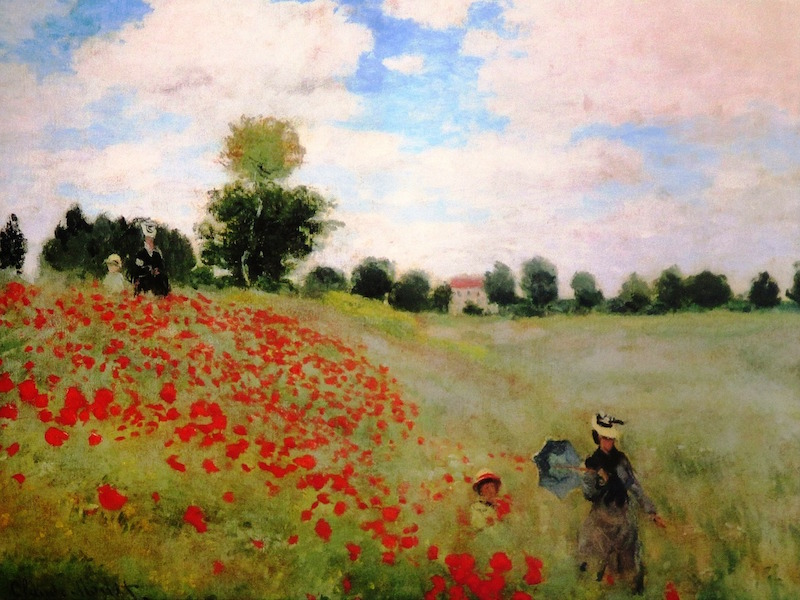

In [9]:
example = Image.open("images/monet_800600.jpg")
example

In [10]:
# Compute Gram matrix for style cost
def gram_matrix(A):
    return tf.linalg.matmul(A, A, transpose_b=True)

In [11]:

gram_matrix_test(gram_matrix)

GA = 
tf.Tensor(
[[ 63.193256  -26.729713   -7.732155 ]
 [-26.729713   12.775055   -2.5164719]
 [ -7.732155   -2.5164719  23.746586 ]], shape=(3, 3), dtype=float32)
All tests passed


In [30]:
# Compute style cost for a single layer
def compute_layer_style_cost(a_S, a_G):
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S = tf.reshape(a_S, shape=[-1, n_C])
    a_G = tf.reshape(a_G, shape=[-1, n_C])
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    return tf.reduce_sum(tf.square(GS - GG)) / (4 * (n_C**2) * (n_H * n_W)**2)

In [31]:

compute_layer_style_cost_test(compute_layer_style_cost)

J_style_layer = tf.Tensor(14.01649, shape=(), dtype=float32)
All tests passed


In [32]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [33]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [34]:
# Style layers with weights for each layer
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)

In [35]:
# Compute total style cost
def compute_style_cost(style_image_output, generated_image_output):
    J_style = 0
    for i, weight in zip(range(len(style_image_output) - 1), STYLE_LAYERS):
        J_style_layer = compute_layer_style_cost(style_image_output[i], generated_image_output[i])
        J_style += weight[1] * J_style_layer
    return J_style

In [36]:
# Combine content and style cost into total cost
def total_cost(J_content, J_style, alpha=10, beta=40):
    return alpha * J_content + beta * J_style

In [37]:

total_cost_test(total_cost)

J = tf.Tensor(32.9832, shape=(), dtype=float32)
All tests passed


(1, 400, 400, 3)


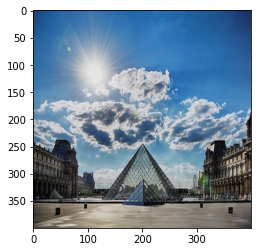

In [38]:
def show_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return Image.fromarray(tensor)

content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


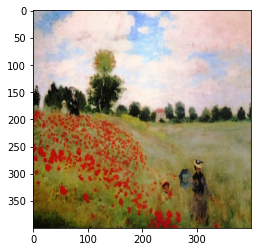

In [39]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


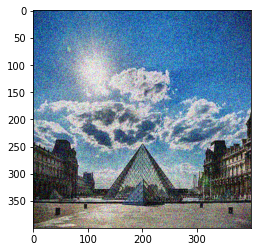

In [40]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [41]:
# Get model outputs for specific layers
def get_model_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(name).output for name, _ in layer_names]
    return tf.keras.Model([vgg.input], outputs)

def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [42]:
# Load model layers for style and content representation
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_model_outputs(vgg, STYLE_LAYERS + content_layer)

In [43]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

In [44]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [45]:

preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [46]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [69]:
# Initialize the generated image
generated_image = tf.Variable(content_image, dtype=tf.float32)

# Define optimization step
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image, a_C, a_S):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        J_content = compute_content_cost(a_C, a_G)
        J_style = compute_style_cost(a_S, a_G)
        J = total_cost(J_content, J_style)
    gradients = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 1.0))
    return J

In [70]:

generated_image = tf.Variable(generated_image)

train_step_test(train_step, generated_image)

tf.Tensor(25700.346, shape=(), dtype=float32)
tf.Tensor(17778.412, shape=(), dtype=float32)
All tests passed


Epoch 0 


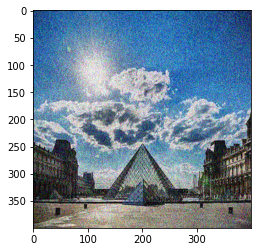

Epoch 250 


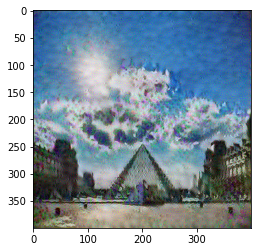

Epoch 500 


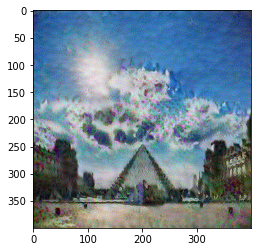

Epoch 750 


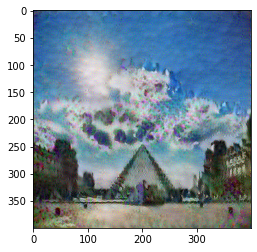

Epoch 1000 


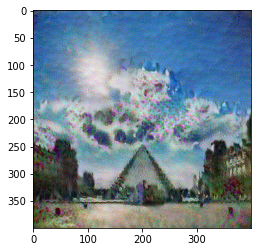

Epoch 1250 


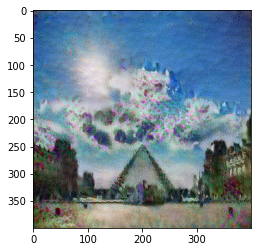

Epoch 1500 


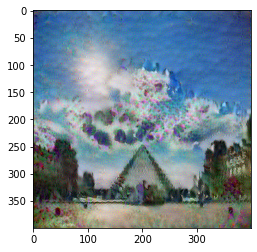

Epoch 1750 


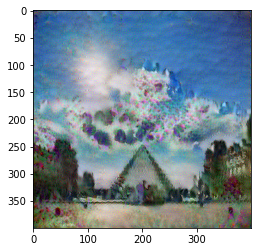

Epoch 2000 


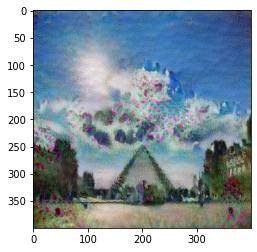

Epoch 2250 


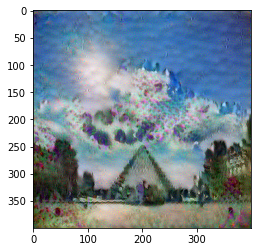

Epoch 2500 


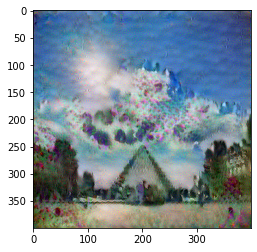

In [71]:
# Show the generated image at some epochs
# Run the neural style transfer process
epochs = 1001
for i in range(epochs):
    cost = train_step(generated_image, content_target, style_target)
    if i % 100 == 0:
        print(f"Iteration {i}, Cost: {cost}")
        image = show_image(generated_image)
        image.save(f"output/image_{i}.jpg")

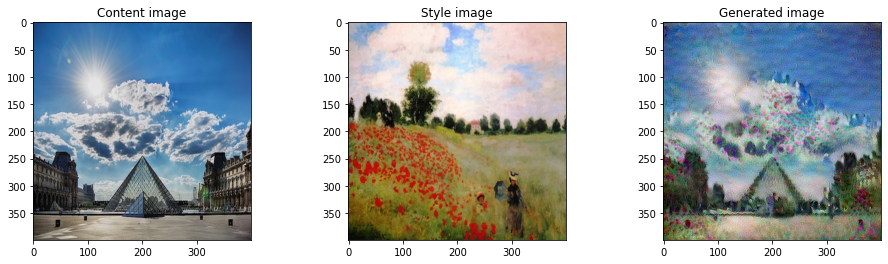

In [72]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()